# ECG Data Handling: Cleaned & Balanced AFIB/SR Dataset

This notebook creates a cleaned and balanced subset of AFIB vs SR records from the original ECG arrhythmia database.

**Steps:**
1. Define project-relative paths
2. Load original file mapping
3. Engineer binary labels (_AFIB, _SR) and balance the dataset
4. Construct output paths and copy/generate .npy files
5. Save cleaned mapping CSV with sanity checks

## 1. Imports

In [8]:
import pandas as pd
import numpy as np
from pathlib import Path
import shutil
from typing import Dict, List, Tuple
import wfdb

print("✓ All imports successful")

✓ All imports successful


## 2. Path Setup

Define all paths relative to the project root—no hardcoded C:\ paths.

In [9]:
# Project structure paths (relative, portable)
PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / "data"

# Raw dataset (input)
RAW_WFDB_DIR = DATA_DIR / "ecg_arrhythmia_dataset_CSV" / "WFDBRecords"
RAW_MAPPING_CSV = DATA_DIR / "ecg_arrhythmia_dataset_CSV" / "file_mapping.csv"

# Cleaned dataset (output)
CLEANED_ROOT = DATA_DIR / "cleaned_balanced_AFIB_SR"
CLEANED_WFDB_DIR = CLEANED_ROOT / "WFDBRecords"
OUT_MAPPING_CSV = CLEANED_ROOT / "file_mapping_cleaned.csv"

# Create output directories
CLEANED_ROOT.mkdir(parents=True, exist_ok=True)
CLEANED_WFDB_DIR.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"RAW_MAPPING_CSV: {RAW_MAPPING_CSV}")
print(f"RAW_WFDB_DIR: {RAW_WFDB_DIR}")
print(f"OUT_MAPPING_CSV: {OUT_MAPPING_CSV}")
print(f"CLEANED_WFDB_DIR: {CLEANED_WFDB_DIR}")
print(f"\n✓ Paths configured (all relative to project root)")

PROJECT_ROOT: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup
RAW_MAPPING_CSV: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\ecg_arrhythmia_dataset_CSV\file_mapping.csv
RAW_WFDB_DIR: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\ecg_arrhythmia_dataset_CSV\WFDBRecords
OUT_MAPPING_CSV: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\file_mapping_cleaned.csv
CLEANED_WFDB_DIR: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\WFDBRecords

✓ Paths configured (all relative to project root)


## 3. Load Original File Mapping

We expect the raw mapping CSV at: `data/ecg_arrhythmia_dataset_CSV/file_mapping.csv`

This CSV contains:
- `record_id`: Unique identifier (e.g., JS00001)
- `AFIB`: Binary column (1 = atrial fibrillation present)
- `SR`: Binary column (1 = sinus rhythm present)
- Other diagnostic and demographic columns

In [10]:
# Load the original mapping CSV
mapping_df = pd.read_csv(RAW_MAPPING_CSV)

print(f"Loaded {len(mapping_df):,} records from {RAW_MAPPING_CSV.name}")
print(f"\nColumns available: {list(mapping_df.columns)[:10]}... (showing first 10)")
print(f"\nDataFrame shape: {mapping_df.shape}")
print(f"\nFirst few rows:")
mapping_df.head()

Loaded 45,150 records from file_mapping.csv

Columns available: ['ecg_path', 'record_id', 'n_signals', 'sampling_frequency', 'signal_length', 'age', 'sex', '1AVB', '2AVB', '2AVB1']... (showing first 10)

DataFrame shape: (45150, 70)

First few rows:


,ecg_path,record_id,n_signals,sampling_frequency,signal_length,age,sex,1AVB,2AVB,2AVB1,...,TWO,UW,VB,VEB,VET,VFW,VPB,VPE,WAVN,WPW
0,01/010/JS00001.csv,JS00001,12,500,5000,85.0,Male,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01/010/JS00002.csv,JS00002,12,500,5000,59.0,Female,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,01/010/JS00004.csv,JS00004,12,500,5000,66.0,Male,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,01/010/JS00005.csv,JS00005,12,500,5000,73.0,Female,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,01/010/JS00006.csv,JS00006,12,500,5000,46.0,Female,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Label Engineering & Balancing

Create binary columns `_AFIB` and `_SR`, then balance the dataset by downsampling the majority class.

In [11]:
# Create binary label columns with underscore prefix
mapping_df['_AFIB'] = mapping_df['AFIB'].astype(int)
mapping_df['_SR'] = mapping_df['SR'].astype(int)

# Filter to records with exactly one of AFIB or SR (no multi-label, no unlabeled)
valid_records = mapping_df[
    ((mapping_df['_AFIB'] == 1) & (mapping_df['_SR'] == 0)) |
    ((mapping_df['_AFIB'] == 0) & (mapping_df['_SR'] == 1))
].copy()

print(f"Original dataset: {len(mapping_df):,} records")
print(f"Valid AFIB-only or SR-only records: {len(valid_records):,} records")

# Count AFIB vs SR before balancing
afib_records = valid_records[valid_records['_AFIB'] == 1]
sr_records = valid_records[valid_records['_SR'] == 1]

print(f"\n--- Before Balancing ---")
print(f"AFIB records: {len(afib_records):,}")
print(f"SR records:   {len(sr_records):,}")

# Balance by downsampling the majority class
min_count = min(len(afib_records), len(sr_records))
afib_balanced = afib_records.sample(n=min_count, random_state=42)
sr_balanced = sr_records.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([afib_balanced, sr_balanced], ignore_index=True)
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n--- After Balancing ---")
print(f"AFIB records: {len(afib_balanced):,}")
print(f"SR records:   {len(sr_balanced):,}")
print(f"Total balanced records: {len(balanced_df):,}")

print(f"\n✓ Dataset balanced successfully")

Original dataset: 45,150 records
Valid AFIB-only or SR-only records: 9,905 records

--- Before Balancing ---
AFIB records: 1,780
SR records:   8,125

--- After Balancing ---
AFIB records: 1,780
SR records:   1,780
Total balanced records: 3,560

✓ Dataset balanced successfully


## 5. Path Construction & File Copying

For each record, construct the output path using the bucket structure:
- Bucket = first 2 digits of `record_id`
- Path = `CLEANED_WFDB_DIR / bucket / record_id / <record_id>.npy`

We'll copy/generate .npy files from the raw WFDB data.

In [12]:
def construct_output_path(record_id: str, cleaned_wfdb_dir: Path) -> Path:
    """
    Construct output path using bucket structure:
    cleaned_wfdb_dir/12/120/120.npy for record_id='120'
    """
    # Extract first 2 characters as bucket
    bucket = record_id[:2]
    
    # Build path: bucket/record_id/record_id.npy
    output_path = cleaned_wfdb_dir / bucket / record_id / f"{record_id}.npy"
    return output_path


def copy_or_generate_npy(
    record_id: str,
    raw_wfdb_dir: Path,
    output_path: Path
) -> bool:
    """
    Copy or generate .npy file from raw WFDB data.
    Returns True if successful, False otherwise.
    """
    output_path.parent.mkdir(parents=True, exist_ok=True)
    
    # Check if already exists
    if output_path.exists():
        return True
    
    # Look for raw .npy file first (if already converted)
    # The raw CSV path is structured like: 01/010/JS00001.csv
    # We need to find the corresponding .npy or read from WFDB format
    
    # Try to find the source file in RAW_WFDB_DIR
    # The record_id starts with 'JS' typically, so we search for it
    possible_sources = list(raw_wfdb_dir.rglob(f"*{record_id}.*"))
    
    # Filter for .npy files first
    npy_sources = [p for p in possible_sources if p.suffix == '.npy']
    if npy_sources:
        shutil.copy2(npy_sources[0], output_path)
        return True
    
    # If no .npy, try to read WFDB format (.hea, .dat files)
    hea_sources = [p for p in possible_sources if p.suffix == '.hea']
    if hea_sources:
        try:
            # Read WFDB record (without extension)
            record_path = str(hea_sources[0].parent / hea_sources[0].stem)
            record = wfdb.rdrecord(record_path)
            
            # Convert to numpy and save
            ecg_data = record.p_signal  # Shape: (n_samples, n_leads)
            np.save(output_path, ecg_data)
            return True
        except Exception as e:
            print(f"  Warning: Failed to read WFDB for {record_id}: {e}")
            return False
    
    # If CSV exists, try reading it
    csv_sources = [p for p in possible_sources if p.suffix == '.csv']
    if csv_sources:
        try:
            csv_data = pd.read_csv(csv_sources[0])
            ecg_array = csv_data.values
            np.save(output_path, ecg_array)
            return True
        except Exception as e:
            print(f"  Warning: Failed to read CSV for {record_id}: {e}")
            return False
    
    print(f"  Warning: No source file found for {record_id}")
    return False


print("Functions defined successfully")

Functions defined successfully


## 6. Create Final Mapping & Save

Select only the required columns and save to CSV.

In [13]:
# Process all records: construct paths and copy files
ecg_paths = []
copied_count = 0
failed_count = 0

print("Processing records and copying files...\n")

for idx, row in balanced_df.iterrows():
    record_id = row['record_id']
    
    # Construct output path
    output_path = construct_output_path(record_id, CLEANED_WFDB_DIR)
    ecg_paths.append(output_path)
    
    # Copy or generate the .npy file
    success = copy_or_generate_npy(record_id, RAW_WFDB_DIR, output_path)
    
    if success:
        copied_count += 1
    else:
        failed_count += 1
    
    # Progress update every 500 records
    if (idx + 1) % 500 == 0:
        print(f"Processed {idx + 1:,}/{len(balanced_df):,} records (copied: {copied_count}, failed: {failed_count})")

print(f"\n✓ Processing complete")
print(f"  Successfully copied/generated: {copied_count:,} files")
print(f"  Failed: {failed_count:,} files")

# Add ecg_path column to the DataFrame
balanced_df['ecg_path'] = ecg_paths

Processing records and copying files...

Processed 500/3,560 records (copied: 500, failed: 0)
Processed 1,000/3,560 records (copied: 1000, failed: 0)
Processed 1,500/3,560 records (copied: 1500, failed: 0)
Processed 2,000/3,560 records (copied: 2000, failed: 0)
Processed 2,500/3,560 records (copied: 2500, failed: 0)
Processed 3,000/3,560 records (copied: 3000, failed: 0)
Processed 3,500/3,560 records (copied: 3500, failed: 0)

✓ Processing complete
  Successfully copied/generated: 3,560 files
  Failed: 0 files


In [ ]:
from pathlib import Path

# Start from balanced_df (after AFIB/SR balancing and ecg_path creation)
balanced_df = balanced_df.copy()

bad_shape = []
bad_values = []

for i, row in balanced_df.iterrows():
    rid = str(row["record_id"])
    f = Path(row["ecg_path"])
    if not f.exists():
        continue
    try:
        data = np.load(f)

        if data.ndim != 2:
            bad_shape.append((rid, f, f"ndim={data.ndim}, shape={data.shape}"))
            continue

        if data.shape[0] > data.shape[1]:
            data = data.T

        if data.shape[0] != 12:
            bad_shape.append((rid, f, f"shape={data.shape}"))
            continue

        if not np.isfinite(data).all():
            bad_values.append((rid, f, "non‑finite values"))

    except Exception as e:
        bad_values.append((rid, f, f"exception: {e}"))

print("Bad shape count:", len(bad_shape))
print("Bad value count:", len(bad_values))

bad_ids = {rid for rid, _, _ in bad_shape} | {rid for rid, _, _ in bad_values}
print("Unique bad record_ids:", len(bad_ids))

# Drop bad records from balanced_df
balanced_df = balanced_df[~balanced_df["record_id"].astype(str).isin(bad_ids)].reset_index(drop=True)

print("Remaining records after dropping bad:", len(balanced_df))

# Now build the final cleaned_mapping from the filtered balanced_df
cleaned_mapping = balanced_df[['record_id', 'ecg_path', '_AFIB', '_SR']].copy()

# Convert ecg_path to a project-relative POSIX path for portability
# Example: data/cleaned_balanced_AFIB_SR/WFDBRecords/JS/JS00001/JS00001.npy
cleaned_mapping['ecg_path'] = cleaned_mapping['ecg_path'].apply(
    lambda p: Path(p)
)
cleaned_mapping['ecg_path'] = cleaned_mapping['ecg_path'].apply(
    lambda p: (p if not p.is_absolute() else p.relative_to(PROJECT_ROOT))
)
cleaned_mapping['ecg_path'] = cleaned_mapping['ecg_path'].apply(lambda p: p.as_posix())

cleaned_mapping.to_csv(OUT_MAPPING_CSV, index=False)

print(f"✓ Saved cleaned mapping to: {OUT_MAPPING_CSV}")
print(f"  Total records: {len(cleaned_mapping):,}")
print("\nFirst 5 rows of cleaned_mapping:")
cleaned_mapping.head()


Bad shape count: 0
Bad value count: 5
Unique bad record_ids: 5
Remaining records after dropping bad: 3555
✓ Saved cleaned mapping to: c:\Users\Adrian\VSCode_Projects\bachelorPrep\SEARCH_AF_detection_OsloMet_BachelorGroup\data\cleaned_balanced_AFIB_SR\file_mapping_cleaned.csv
  Total records: 3,555

First 5 rows of cleaned_mapping:


,record_id,ecg_path,_AFIB,_SR
0,JS36340,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
1,JS04305,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,1,0
2,JS11050,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
3,JS23632,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1
4,JS41351,c:\Users\Adrian\VSCode_Projects\bachelorPrep\S...,0,1


## 7. Cleaned Dataset Analysis

Analyze the final cleaned dataset to understand the distribution of AFIB, SR, and AF records.

CLEANED DATASET ANALYSIS

📊 Total Records: 3,555

🫀 AFIB Records:
   Count: 1,780
   Percentage: 50.07%

💓 SR (Sinus Rhythm) Records:
   Count: 1,775
   Percentage: 49.93%

⚡ AF Records:
   Note: AF column not found in original data.
   Using _AFIB as proxy for AF:
   Count: 1,780
   Percentage: 50.07%

⚖️  Dataset Balance:
   AFIB vs Non-AFIB ratio: 1780:1775
   SR vs Non-SR ratio: 1775:1780


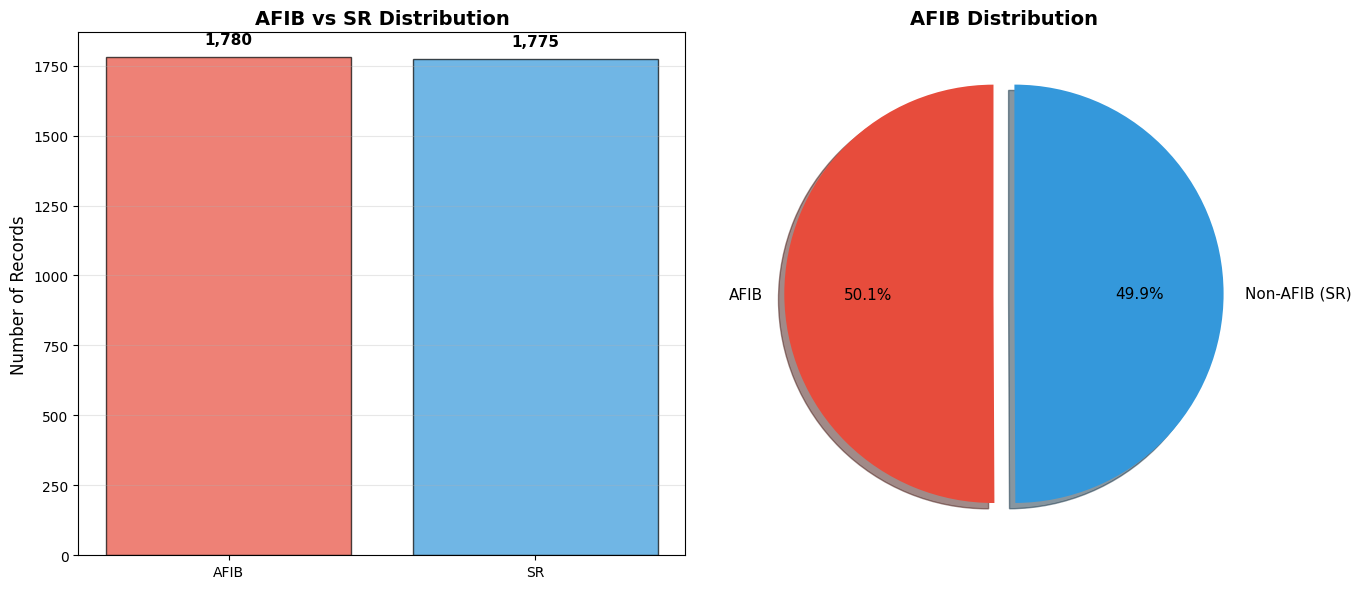


✓ Dataset analysis complete!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Ensure paths are defined
if 'OUT_MAPPING_CSV' not in dir():
    PROJECT_ROOT = Path.cwd()
    DATA_DIR = PROJECT_ROOT / "data"
    CLEANED_ROOT = DATA_DIR / "cleaned_balanced_AFIB_SR"
    OUT_MAPPING_CSV = CLEANED_ROOT / "file_mapping_cleaned.csv"
    RAW_MAPPING_CSV = DATA_DIR / "ecg_arrhythmia_dataset_CSV" / "file_mapping.csv"

print("=" * 70)
print("CLEANED DATASET ANALYSIS")
print("=" * 70)

# Load the cleaned mapping to ensure we're analyzing the final dataset
cleaned_data = pd.read_csv(OUT_MAPPING_CSV)

# Total records
total_records = len(cleaned_data)
print(f"\n📊 Total Records: {total_records:,}")

# AFIB Analysis
afib_count = cleaned_data['_AFIB'].sum()
afib_percentage = (afib_count / total_records) * 100
print(f"\n🫀 AFIB Records:")
print(f"   Count: {afib_count:,}")
print(f"   Percentage: {afib_percentage:.2f}%")

# SR (Sinus Rhythm) Analysis
sr_count = cleaned_data['_SR'].sum()
sr_percentage = (sr_count / total_records) * 100
print(f"\n💓 SR (Sinus Rhythm) Records:")
print(f"   Count: {sr_count:,}")
print(f"   Percentage: {sr_percentage:.2f}%")

# AF (Atrial Fibrillation) - checking if there's an AF column in the original data
# Load original mapping to check for AF column
if 'mapping_df' not in dir() and 'RAW_MAPPING_CSV' in dir():
    mapping_df = pd.read_csv(RAW_MAPPING_CSV)

# Check if mapping_df exists and has AF column
if 'mapping_df' in dir() and 'AF' in mapping_df.columns:
    # Merge with original to get AF information
    merged_analysis = cleaned_data.merge(
        mapping_df[['record_id', 'AF']], 
        on='record_id', 
        how='left'
    )
    af_count = int(merged_analysis['AF'].sum())
    af_percentage = (af_count / total_records) * 100
    print(f"\n⚡ AF (Atrial Fibrillation) Records:")
    print(f"   Count: {af_count:,}")
    print(f"   Percentage: {af_percentage:.2f}%")
else:
    # AF might be the same as AFIB
    print(f"\n⚡ AF Records:")
    print(f"   Note: AF column not found in original data.")
    print(f"   Using _AFIB as proxy for AF:")
    print(f"   Count: {afib_count:,}")
    print(f"   Percentage: {afib_percentage:.2f}%")

# Balance check
print(f"\n⚖️  Dataset Balance:")
print(f"   AFIB vs Non-AFIB ratio: {afib_count}:{total_records - afib_count}")
print(f"   SR vs Non-SR ratio: {sr_count}:{total_records - sr_count}")

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart for AFIB vs SR
categories = ['AFIB', 'SR']
counts = [afib_count, sr_count]
colors = ['#e74c3c', '#3498db']

axes[0].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Number of Records', fontsize=12)
axes[0].set_title('AFIB vs SR Distribution', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(i, count + max(counts)*0.02, f'{count:,}', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
labels_pie = ['AFIB', 'Non-AFIB (SR)']
sizes_pie = [afib_count, sr_count]
colors_pie = ['#e74c3c', '#3498db']
explode = (0.05, 0.05)

axes[1].pie(sizes_pie, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
           startangle=90, explode=explode, shadow=True, textprops={'fontsize': 11})
axes[1].set_title('AFIB Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("✓ Dataset analysis complete!")
print("=" * 70)